## Create price curve and plot it

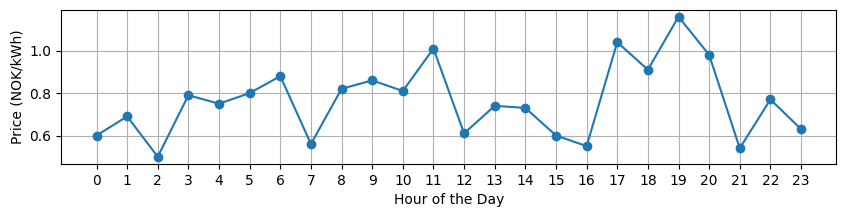

In [262]:
import random
import matplotlib.pyplot as plt
import numpy as np

random.seed(71)

def generate_price_curve(peak_hours, morning_hours):
    price_curve = {}
    for hour in range(24):
        if hour in peak_hours:
            price_curve[hour] = round(random.uniform(0.9, 1.3), 2)  # Peak price range: 0.2 to 1.0 NOK/kWh
        elif hour in morning_hours:
            price_curve[hour] = round(random.uniform(0.8, 1.1), 2)
        else:
            price_curve[hour] = round(random.uniform(0.5, 0.8), 2)  # Default to off-peak price for non-defined hours
    return price_curve

# Define peak and off-peak hours (for example)
peak_hours = {17, 18, 19, 20}  # 5:00 pm to 8:00 pm
morning_hours = {6, 8, 9, 10, 11}

# Generate a random price curve
price_curve = generate_price_curve(peak_hours, morning_hours)

# Plot the generated price curve
plt.figure(figsize=(10, 2))
plt.plot(price_curve.keys(), price_curve.values(), marker='o', linestyle='-')
# plt.title("RTC Price Curve")
plt.xlabel("Hour of the Day")
plt.ylabel("Price (NOK/kWh)")
plt.grid(False)
plt.xticks(range(24))
plt.grid(True)
plt.savefig("rtp.eps")
plt.show()


## Problem 2

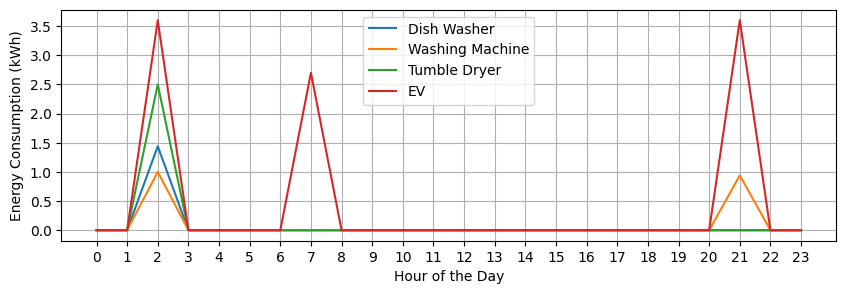

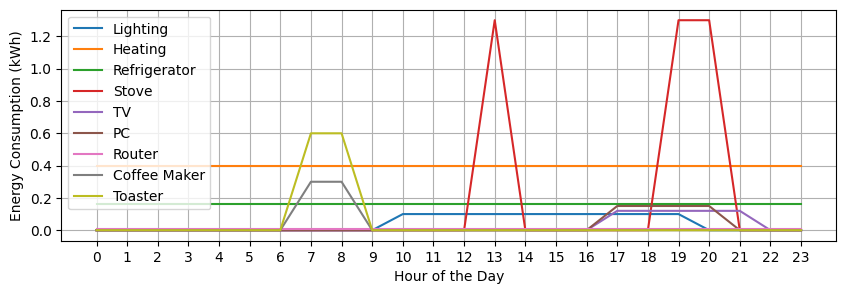

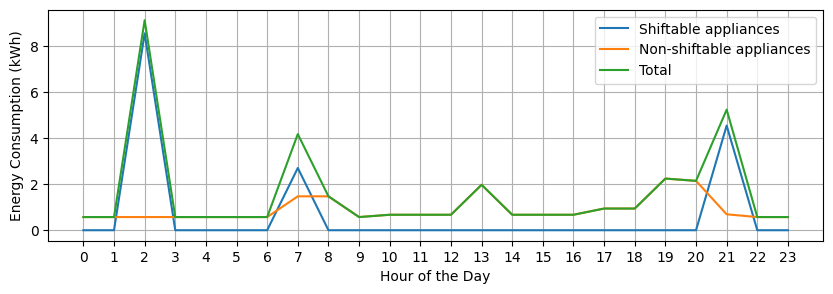

Energy cost in NOK:  25.671129999999998
Peak load kW: 9.110999999999999


In [263]:
import pyomo.environ as pe

l_h = 0.1 #hourly consumption of incandescent lighting kWh
h_h = 9.6/24 #hourly consumption of heating kWh
r_h = 3.96/24 #hourly consumption of refrigerator kWh
s_h = 3.9/3 #hourly consumption of stove kWh
tv_h = 0.6/5 #hourly consumption of refrigerator kWh
pc_h = 0.6/4 #hourly consumption of pc kWh
rout_h = 0.006 #hourly consumption of wifi router kWh
cm_h = 0.3 #hourly consumption of coffee maker kWh
toast_h = 0.6 #hourly consumption of toaster kWh



#Energy consumption for non-shiftable appliances per appliance, per hour kWh
x_ns = np.asarray([[l_h if i >= 10 and i < 20 else 0 for i in range(24)],
                   [h_h for i in range(24)],
                   [r_h for i in range(24)],
                   [s_h if (i>=19  and i<21) or (i>=13 and i<14) else 0 for i in range(24)],
                   [tv_h if i>=17 and i<22 else 0 for i in range(24)],
                   [pc_h if i>=17 and i<21 else 0 for i in range(24)],
                   [rout_h for i in range(24)],
                   [cm_h if i>=7 and i<9 else 0 for i in range(24)],
                   [toast_h if i>=7 and i<9 else 0 for i in range(24)]])

ns_app_names = ["Lighting","Heating","Refrigerator","Stove","TV","PC","Router","Coffee Maker","Toaster"]
app_names = ['Dish Washer', 'Washing Machine', 'Tumble Dryer','EV']
E         = [1.44, 1.94, 2.5, 9.9] #daily energy consumption of the 4 shiftable appliances, kWh
power_lim = [1.8, 1, 3 , 3.6] #power rate of these appliances. I have just searched them online when not available at reference 2. The EV one is taken from the lesson slides, for a nissan leaf. in kWh

m = pe.ConcreteModel()

m.nt    = pe.Param(initialize = len(price_curve), domain=pe.Integers)
m.T     = pe.Set(initialize = range(m.nt()))
m.price = pe.Param(m.T, initialize = price_curve)
m.I     = pe.RangeSet(0,len(E)-1)

m.x_s   = pe.Var(m.I, m.T, domain=pe.NonNegativeReals) #hourly energy consumption of shiftable appliance i at hour t

# Define objective function
def obj_rule(model):
    # Add cost of non-shiftable appliances
    total_cost = sum(model.price[t] * (sum(model.x_s[i, t] for i in model.I) + sum(x_ns[i, t] for i in range(len(x_ns)))) for t in model.T)
    return total_cost

m.obj = pe.Objective(rule=obj_rule, sense=pe.minimize)

m.cons = pe.ConstraintList() #create a list of constraints
for i in m.I:
  m.cons.add(expr = sum(m.x_s[i,t] for t in m.T)==E[i]) #constraint for total daily energy use
  for t in m.T:
    m.cons.add(expr = m.x_s[i,t] <= power_lim[i])
m.cons.add(expr = sum(m.x_s[3,t] for t in range(8,18))==0) #charging hours constraint of EV
  
results = pe.SolverFactory('cbc').solve(m)

# Extract the solution values
solution_values = {(i, t): pe.value(m.x_s[i, t]) for i in m.I for t in m.T}

# Data for shiftable appliances
shiftable_sum = [sum(solution_values[i, t] for i in range(len(app_names))) for t in m.T]

# Data for non-shiftable appliances
non_shiftable_sum = [sum(x_ns[i, t] for i in range(len(ns_app_names))) for t in m.T]

# Sum of shiftable and non-shiftable appliances
total_sum = [shiftable_sum[t] + non_shiftable_sum[t] for t in range(len(m.T))]

# Plot the energy consumption profile
plt.figure(figsize=(10, 3))
for i in range(len(E)):
    plt.plot(range(len(m.T)), [solution_values[i, t] for t in m.T], label=f"{app_names[i]}")
# plt.title("Energy Consumption Profile of Shiftable Appliances")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (kWh)")
plt.xticks(range(len(m.T)))
plt.legend()
plt.grid(True)
plt.savefig("shift.png", transparent=False, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 3))
for i in range(len(ns_app_names)):
    plt.plot(range(len(m.T)), [x_ns[i, t] for t in m.T], label=f"{ns_app_names[i]}")
# plt.title("Energy Consumption Profile of Non-Shiftable Appliances")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (kWh)")
plt.xticks(range(len(m.T)))
plt.legend()
plt.grid(True)
plt.savefig("nonshift.png", transparent=False, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(range(len(m.T)), shiftable_sum, label="Shiftable appliances")
plt.plot(range(len(m.T)), non_shiftable_sum, label="Non-shiftable appliances")
plt.plot(range(len(m.T)), total_sum, label="Total")
# plt.title("Total Energy Consumption Profile")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (kWh)")
plt.xticks(range(len(m.T)))
plt.legend()
plt.grid(True)
plt.savefig("total.png", transparent=False, bbox_inches='tight')
plt.show()

# Calculate the total energy consumption (peak load) at each time period
peak_load = [sum(solution_values[i, t] for i in range(len(app_names))) +
             sum(x_ns[i, t] for i in range(len(ns_app_names))) for t in m.T]

# Find the maximum peak load
max_peak_load = max(peak_load)

print("Energy cost in NOK: ", pe.value(sum(m.price[t] * (sum(m.x_s[i, t] for i in m.I) + sum(x_ns[i, t] for i in range(len(x_ns)))) for t in m.T)))
print("Peak load kW:", max_peak_load)

### Problem 4

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Slope: 0.84, Intercept: 3.44, R-value: 0.999, P-value: 0.00, Standard Error: 0.03


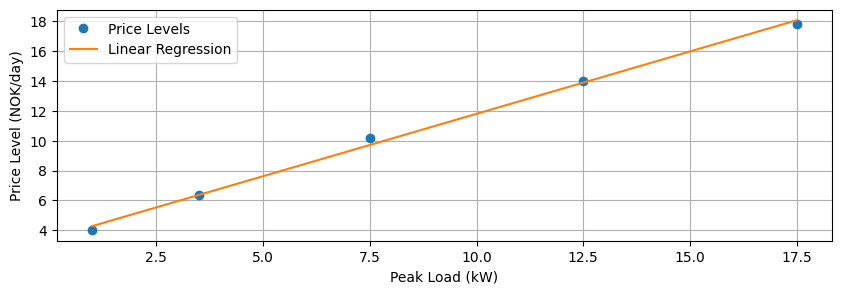

In [264]:
from scipy import stats 

#Price levels for peak load ranges (nok and kW) taken from Elvia, divided by 30 to represent daily price
price_levels = np.array([120, 190, 305, 420, 535])/30
ranges = np.array([[0, 2], [2, 5], [5, 10], [10, 15], [15, 20]])

# Calculate the midpoints of each range
midpoints = (ranges[:, 0] + ranges[:, 1]) / 2

slope, intercept, r_value, p_value, std_err = stats.linregress(midpoints,price_levels)
Y_pred = intercept + midpoints*slope

print(f"Slope: {slope:.2f}, Intercept: {intercept:.2f}, R-value: {r_value:.3f}, P-value: {p_value:.2f}, Standard Error: {std_err:.2f}")

# Plotting
plt.figure(figsize=(10, 3))
plt.plot(midpoints, price_levels, 'o', label='Price Levels')
plt.plot(midpoints, Y_pred, label='Linear Regression')
plt.xlabel('Peak Load (kW)')
plt.ylabel('Price Level (NOK/day)')
# plt.title('Linear Regression of Fastledd Price Levels')
plt.legend()
plt.grid(True)
plt.savefig("pricelvl.eps", transparent=False, bbox_inches='tight')
plt.show()

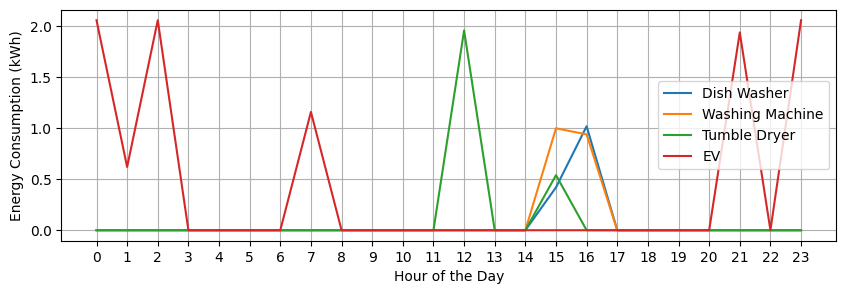

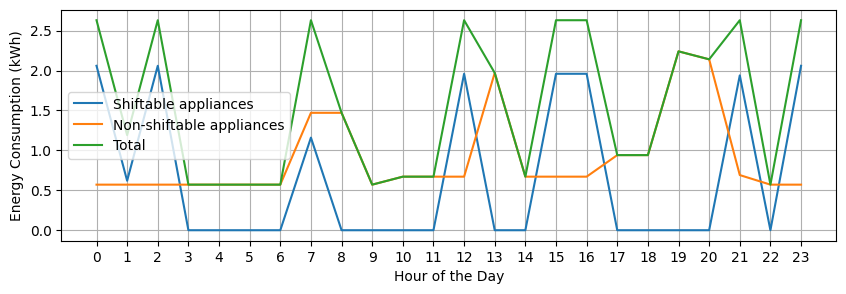

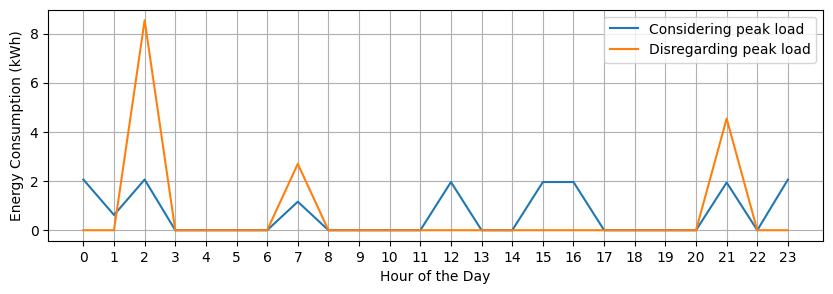

Energy cost in NOK:  26.575929999999996
Peak load kW: 2.6310000000000002
Peak load kW: 2.631


In [265]:
m = pe.ConcreteModel()

m.nt    = pe.Param(initialize = len(price_curve), domain=pe.Integers)
m.T     = pe.Set(initialize = range(m.nt()))
m.price = pe.Param(m.T, initialize = price_curve)
m.I     = pe.RangeSet(0,len(E)-1)

m.x_s   = pe.Var(m.I, m.T, domain=pe.NonNegativeReals) #hourly energy consumption of shiftable appliance i at hour t
m.L     = pe.Var(domain=pe.NonNegativeReals)

# Define objective function
def obj_rule(model):
    # Add cost of non-shiftable appliances
    total_cost = sum(model.price[t] * (sum(model.x_s[i, t] for i in model.I) + sum(x_ns[i, t] for i in range(len(x_ns)))) for t in model.T)
    peak_load_cost = intercept + slope*m.L #add fastledd cost related to peak load
    
    return total_cost + peak_load_cost

m.obj = pe.Objective(rule=obj_rule, sense=pe.minimize)

m.cons = pe.ConstraintList() #create a list of constraints
for i in m.I:
  m.cons.add(expr = sum(m.x_s[i,t] for t in m.T)==E[i]) #constraint for total daily energy use
  for t in m.T:
    m.cons.add(expr = m.x_s[i,t] <= power_lim[i]) #constraint for appliance power limit
    m.cons.add(expr = sum(m.x_s[i, t] for i in m.I) + sum(x_ns[i, t] for i in range(len(x_ns))) <= m.L) #constraint for peak load
m.cons.add(expr = sum(m.x_s[3,t] for t in range(8,18))==0) #charging hours constraint of EV
  
results = pe.SolverFactory('cbc').solve(m)

# Extract the solution values
solution_values = {(i, t): pe.value(m.x_s[i, t]) for i in m.I for t in m.T}

# Data for shiftable appliances
shiftable_sum_q4 = [sum(solution_values[i, t] for i in range(len(app_names))) for t in m.T]

# Data for non-shiftable appliances
non_shiftable_sum = [sum(x_ns[i, t] for i in range(len(ns_app_names))) for t in m.T]

# Sum of shiftable and non-shiftable appliances
total_sum = [shiftable_sum_q4[t] + non_shiftable_sum[t] for t in range(len(m.T))]

# Plot the energy consumption profile
plt.figure(figsize=(10, 3))
for i in range(len(E)):
    plt.plot(range(len(m.T)), [solution_values[i, t] for t in m.T], label=f"{app_names[i]}")
# plt.title("Energy Consumption Profile of Shiftable Appliances With Peak Load")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (kWh)")
plt.xticks(range(len(m.T)))
plt.legend()
plt.grid(True)
plt.savefig("shift_q4.png", transparent=False, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(range(len(m.T)), shiftable_sum_q4, label="Shiftable appliances")
plt.plot(range(len(m.T)), non_shiftable_sum, label="Non-shiftable appliances")
plt.plot(range(len(m.T)), total_sum, label="Total")
# plt.title("Total Energy Consumption Profile With Peak Load")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (kWh)")
plt.xticks(range(len(m.T)))
plt.legend()
plt.grid(True)
plt.savefig("total_q4.png", transparent=False, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(range(len(m.T)), shiftable_sum_q4, label="Considering peak load")
plt.plot(range(len(m.T)), shiftable_sum, label="Disregarding peak load")
# plt.title("Comparison of Energy Consumption of Shiftable Devices According to Peak Load Considerations")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (kWh)")
plt.xticks(range(len(m.T)))
plt.legend()
plt.grid(True)
plt.savefig("shift_com.png", transparent=False, bbox_inches='tight')
plt.show()

# Calculate the total energy consumption (peak load) at each time period
peak_load = [sum(solution_values[i, t] for i in range(len(app_names))) +
             sum(x_ns[i, t] for i in range(len(ns_app_names))) for t in m.T]

# Find the maximum peak load
max_peak_load = max(peak_load)

print("Energy cost in NOK: ", pe.value(sum(m.price[t] * (sum(m.x_s[i, t] for i in m.I) + sum(x_ns[i, t] for i in range(len(x_ns)))) for t in m.T)))
print("Peak load kW:", max_peak_load)
print("Peak load kW:", pe.value(m.L))

